<a href="https://colab.research.google.com/github/jannekelly/TCC/blob/Resultado-1/cnnTCC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando biblioteca para salvar o modelo em .h5

In [ ]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

#Importando bibliotecas necessarias

In [1]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os 
import cv2
import numpy as np

from keras.layers import Input,Lambda,Dense,Flatten
#from keras.models import Model, Sequential

#from keras.applications.vgg16 import VGG16, preprocess_input 
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

#Autorizando acesso ao drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')
#Clique no link a seguir para dar permissão ao colab para utilizar a conta drive, em seguida copie o código de autorização e cole no input requerido

Mounted at /content/drive


#Augmentation

In [ ]:
def reshape_dir_images(path_dir, shape=(150,150)):
    
    os.chdir(path_dir)
    
    for path_image in os.listdir(path_dir):
        
        img = cv2.imread(path_image)
        if img is None:#If the image data is empty, skip
            continue
            img_resize = cv2.resize(img, shape, interpolation=cv2.INTER_AREA)
            cv2.imwrite(path_image, img_resize) 

In [ ]:
def data_augmentation(list_paths, qtd_images_create=10):

    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        fill_mode='nearest')
    
    for path_class in list_paths:
        
        reshape_dir_images(path_dir=path_class, shape=(150,150)) # Fazendo o reshape
        
        os.chdir(path_class)
        for path_image in os.listdir(path_class):
            img = load_img(f"{path_image}")
            img_np = img_to_array(img) 
            img_np = img_np.reshape((1,) + img_np.shape)
            
            i = 0
            for batch in datagen.flow(img_np, batch_size=1,
                                  save_to_dir=".", save_prefix='aug', save_format='jpeg'):
                i += 1
                if i > qtd_images_create:     ## creates 10 image form 1 image 
                    break       

In [ ]:
paths_classes = [
    
    "/content/drive/My Drive/CNN-TCC/dataset_original/train/apple",
    "/content/drive/My Drive/CNN-TCC/dataset_original/train/banana",
    "/content/drive/My Drive/CNN-TCC/dataset_original/train/orange",
    
   

]

In [ ]:
data_augmentation(paths_classes, qtd_images_create=10)

#Definindo o dataset

In [17]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/drive/My Drive/CNN-TCC/dataset_original/train",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(150,150),
  batch_size=256)

Found 1244 files belonging to 3 classes.


In [18]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
   "/content/drive/My Drive/CNN-TCC/dataset_original/test",
  subset=None,
  seed=123,
  image_size=(150,150),
  batch_size=256)

Found 150 files belonging to 3 classes.


In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/My Drive/CNN-TCC/dataset_original/train",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(150,150),
  batch_size=256)

Found 1244 files belonging to 3 classes.
Using 996 files for training.


In [6]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

#Criando o modelo

In [7]:
num_classes = 3

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3,activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes,activation='softmax')
])

model.build(input_shape=(None,150,150,3))

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0

#Modelo VGG16

In [ ]:
### Defining Image size
IMAGE_SIZE = [150, 150]

### Loading model
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


### Freezing layers
for layer in vgg.layers:  
    layer.trainable = False
    
### adding a 3 node final layer for predicion
#x = Flatten()(vgg.output)
#prediction = Dense(3, activation='softmax')(x)

model = Sequential(vgg.layers)
model.add(layers.experimental.preprocessing.Rescaling(1./255))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(3,activation='softmax'))
#model.add(layers.Dense(3, activation='relu'))

### Generating Summary
model.summary()

#Compilando e Treinando o Modelo

In [9]:
model.compile( loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),  
               optimizer='adam',  
               metrics=['accuracy'])


In [10]:

epochs=50

model_vgg = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


4/4 [==============================] - 451s 28s/step - loss: 2.5210 - accuracy: 0.3886 - val_loss: 1.2287 - val_accuracy: 0.4153
Epoch 2/50
4/4 [==============================] - 3s 373ms/step - loss: 0.8070 - accuracy: 0.7058 - val_loss: 0.3754 - val_accuracy: 0.8871
Epoch 3/50
4/4 [==============================] - 3s 384ms/step - loss: 0.5645 - accuracy: 0.8163 - val_loss: 0.4127 - val_accuracy: 0.8669
Epoch 4/50
4/4 [==============================] - 3s 375ms/step - loss: 0.2807 - accuracy: 0.8916 - val_loss: 0.1412 - val_accuracy: 0.9556
Epoch 5/50
4/4 [==============================] - 3s 370ms/step - loss: 0.2089 - accuracy: 0.9177 - val_loss: 0.1174 - val_accuracy: 0.9637
Epoch 6/50
4/4 [==============================] - 3s 368ms/step - loss: 0.1305 - accuracy: 0.9548 - val_loss: 0.1212 - val_accuracy: 0.9476
Epoch 7/50
4/4 [==============================] - 3s 368ms/step - loss: 0.1067 - accuracy: 0.9679 - val_loss: 0.1699 - val_accuracy: 0.9315
Epoch 8/50
4/4 [===============

#Plotando dados de acurácia e loss

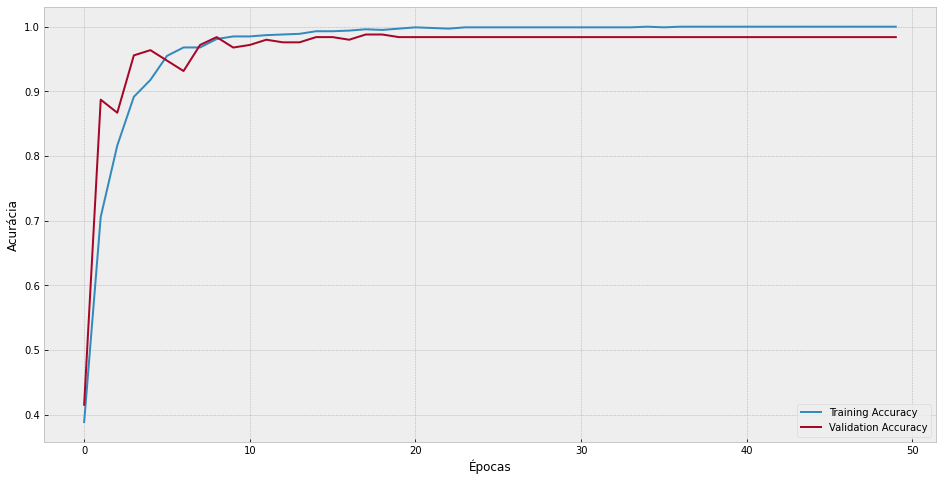

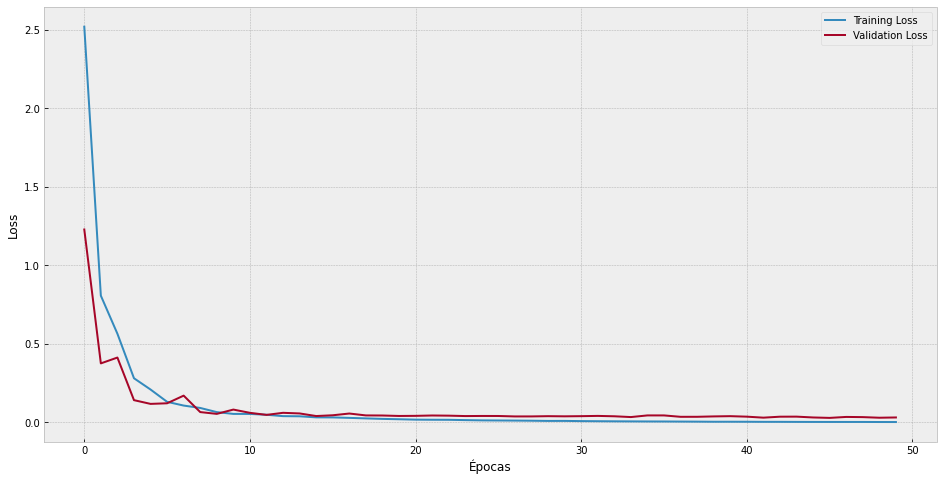

96.43548506498337


In [11]:
acc = model_vgg.history['accuracy']
val_acc = model_vgg.history['val_accuracy']

loss = model_vgg.history['loss']
val_loss = model_vgg.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16,8))
#plt.subplot(1, 2, 1)
plt.style.use('bmh')
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
#plt.title('Accuracy')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.show()
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16,8))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
#plt.title('Training Loss')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()
acu=0
for i in val_acc:
  acu+= i
print((acu/len(val_acc))*100)

#Testando o Modelo

In [20]:
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy*100)



1/1 [==============================] - 0s 352ms/step - loss: 0.1153 - accuracy: 0.9667
Test accuracy : 96.66666388511658


Esta imagem provavelmente pertence a classe apple com um confiança de 57.61%.


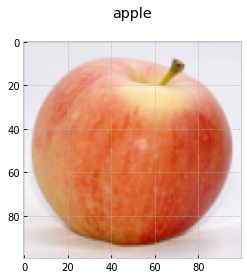

In [12]:
class_names = train_ds.class_names
#print(class_names)

img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/CNN-TCC/dataset_original/test/apple/1.png", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plt.figure()
plt.plot()
img = plt.imread("/content/drive/My Drive/CNN-TCC/dataset_original/test/apple/1.png")
plt.imshow(np.squeeze(img))

title=class_names[np.argmax(score)]
plt.title(title, y=1.08)
print(
    "Esta imagem provavelmente pertence a classe {} com um confiança de {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


Esta imagem provavelmente pertence a classe banana com um confiança de 57.61%.


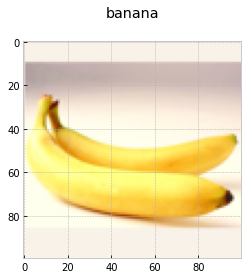

In [13]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/CNN-TCC/dataset_original/test/banana/29.png", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plt.figure()
plt.plot()
img = plt.imread("/content/drive/My Drive/CNN-TCC/dataset_original/test/banana/29.png")
plt.imshow(np.squeeze(img))

title=class_names[np.argmax(score)]
plt.title(title, y=1.08)
print(
    "Esta imagem provavelmente pertence a classe {} com um confiança de {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Esta imagem provavelmente pertence a classe orange com um confiança de 56.43%.


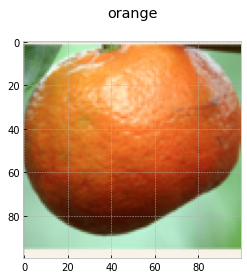

In [14]:
img = keras.preprocessing.image.load_img(
    "/content/drive/My Drive/CNN-TCC/dataset_original/test/orange/29.png", target_size=(150,150)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
plt.figure()
plt.plot()
img = plt.imread("/content/drive/My Drive/CNN-TCC/dataset_original/test/orange/29.png")
plt.imshow(np.squeeze(img))

title=class_names[np.argmax(score)]
plt.title(title, y=1.08)
print(
    "Esta imagem provavelmente pertence a classe {} com um confiança de {:.2f}%."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

#Salvando o Modelo .h5

In [ ]:
model.save('/content/drive/My Drive/CNN-TCC/data/model_aume_frutas.h5')

#Testes

In [ ]:
import os
import numpy as np

import tensorflow.keras
from PIL import Image, ImageOps
import numpy as np

def model_predict(img_path):
    np.set_printoptions(suppress=True)
    
    # Create the array of the right shape to feed into the keras model
    # The 'length' or number of images you can put into the array is
    # determined by the first position in the shape tuple, in this case 1.
    data = np.ndarray(shape=(1, 150, 150, 3), dtype=np.float32)
    
    # Replace this with the path to your image
    image = Image.open(img_path)
    #resizing the image to be at least 150x150
    
    size = (150, 150)
    image = ImageOps.fit(image, size, Image.ANTIALIAS)
    
    #turn the image into a numpy array
    image_array = np.asarray(image)
    
    # Normalize the image
    normalized_image_array = (image_array.astype(np.float32) / 127.0) - 1
    
    # Load the image into the array
    data[0] = normalized_image_array
    
        
    # Load the model
    model = tensorflow.keras.models.load_model('/content/drive/My Drive/CNN-TCC/data/model_frutas.h5')
    _,acc=model.evaluate(test_set,test_datagen)
    
    # run the inference
    
    preds = ""
    prediction = model.predict(data)
    
    if np.argmax(prediction)==2:
        preds = "laranja"
    elif np.argmax(prediction)==0:
        preds = "apple"
    elif np.argmax(prediction)==1:
        preds = "banana"

    return preds,acc

In [ ]:
#from keras.preprocessing import image
def _LoadImage(filePath):
  test_image = image.load_img(filePath, target_size = (150,150))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis=0)
  return test_image
test_this = _LoadImage("/content/drive/My Drive/CNN-TCC/data/test/apple/1.png")


result = model.predict(test_this)
print(result)

[[1. 0. 0.]]


Text(0.5, 1.08, 'apple')

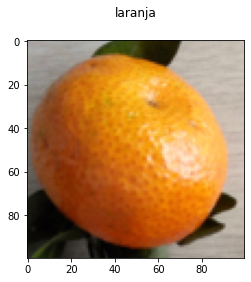

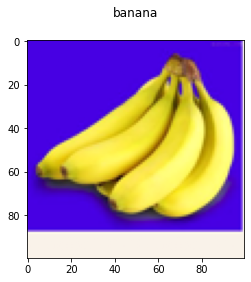

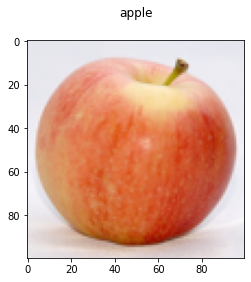

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot()
img = plt.imread("/content/drive/My Drive/CNN-TCC/data/test/orange/1.png")
plt.imshow(np.squeeze(img))

title=model_predict("/content/drive/My Drive/CNN-TCC/data/test/orange/1.png")
plt.title(title, y=1.08)

plt.figure()
plt.plot()
img1 = plt.imread("/content/drive/My Drive/CNN-TCC/data/test/banana/1.png")
plt.imshow(np.squeeze(img1))
title1=model_predict("/content/drive/My Drive/CNN-TCC/data/test/banana/1.png")
plt.title(title1,y=1.08)

plt.figure()
plt.plot()
img2 = plt.imread("/content/drive/My Drive/CNN-TCC/data/test/apple/1.png")
plt.imshow(np.squeeze(img2))
title2=model_predict("/content/drive/My Drive/CNN-TCC/data/test/apple/1.png")
plt.title(title2, y=1.08)


In [ ]:
 import numpy as np
 from sklearn.metrics import *

 dx = 5
 xx = np.argmax(img2,axis=1)[:5]
 yy = np.argmax(test_data ,axis = 1)[:5]
 print(xx)
 print(yy)
 #print('computed AUC using sklearn.metrics.auc: {}'.format(auc(xx,yy)))
 #print('computed AUC using np.trapz: {}'.format(np.trapz(yy, dx = dx)))

